# Brain Stroke Prediction

In [27]:
#importing the necessary libraries for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score,
    precision_score, f1_score, roc_auc_score
)


In [28]:
data = pd.read_csv(r"C:\Users\kirta\Downloads\brain_stroke.csv")

### Data Cleanup and initial setup

In [29]:
data.info

<bound method DataFrame.info of       gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1       Male  80.0             0              1          Yes        Private   
2     Female  49.0             0              0          Yes        Private   
3     Female  79.0             1              0          Yes  Self-employed   
4       Male  81.0             0              0          Yes        Private   
...      ...   ...           ...            ...          ...            ...   
4976    Male  41.0             0              0           No        Private   
4977    Male  40.0             0              0          Yes        Private   
4978  Female  45.0             1              0          Yes       Govt_job   
4979    Male  40.0             0              0          Yes        Private   
4980  Female  80.0             1              0          Yes        Private   

     Residence_type

In [30]:
data.describe 

<bound method NDFrame.describe of       gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1       Male  80.0             0              1          Yes        Private   
2     Female  49.0             0              0          Yes        Private   
3     Female  79.0             1              0          Yes  Self-employed   
4       Male  81.0             0              0          Yes        Private   
...      ...   ...           ...            ...          ...            ...   
4976    Male  41.0             0              0           No        Private   
4977    Male  40.0             0              0          Yes        Private   
4978  Female  45.0             1              0          Yes       Govt_job   
4979    Male  40.0             0              0          Yes        Private   
4980  Female  80.0             1              0          Yes        Private   

     Residence_ty

In [31]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [32]:
data.duplicated().sum()

0

In [33]:
data['stroke'].value_counts()

stroke
0    4733
1     248
Name: count, dtype: int64

In [34]:
#dropping the not needed variables and encoding the rest into 0 and 1 for easy analysis
data = data.drop(columns=['ever_married', 'Residence_type', 'work_type'])

data_encoded = pd.get_dummies(data, drop_first=True)

X = data_encoded.drop('stroke', axis=1)
y = data_encoded['stroke']



### EDA - Exploratory Data Analysis

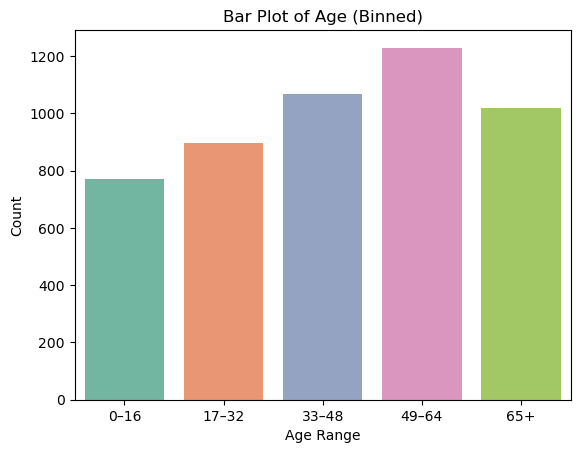

In [35]:
bins = [0, 16, 32, 48, 64, 10000]
labels = ['0–16', '17–32', '33–48', '49–64', '65+']

data['age_binned'] = pd.cut(data['age'], bins=bins, labels=labels)

sb.countplot(x='age_binned', data=data, hue='age_binned', palette='Set2', legend=False)

plt.title('Bar Plot of Age (Binned)')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.show()


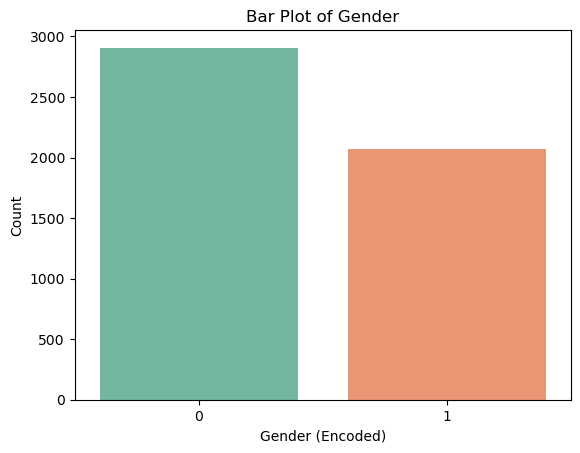

In [36]:
colors = ['#66c2a5', '#fc8d62']

data['gender_encoded'] = data['gender'].astype('category').cat.codes

sb.countplot(x='gender_encoded', data=data, hue='gender_encoded', palette=sb.color_palette(colors), legend=False)

plt.title('Bar Plot of Gender')
plt.xlabel('Gender (Encoded)')
plt.ylabel('Count')
plt.show()


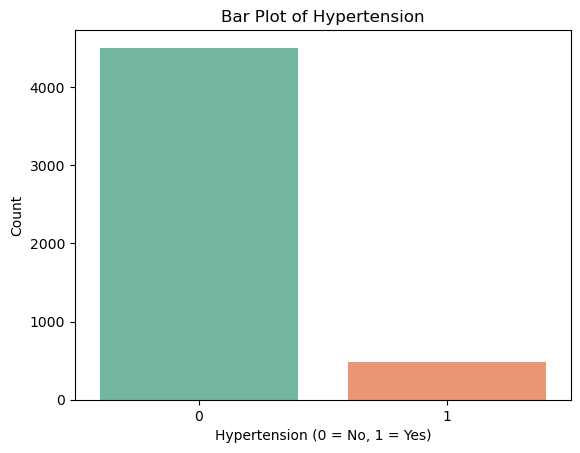

In [37]:
colors = ['#66c2a5', '#fc8d62']

sb.countplot(x='hypertension', data=data, hue='hypertension', palette=sb.color_palette(colors), legend=False)

plt.title('Bar Plot of Hypertension')
plt.xlabel('Hypertension (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


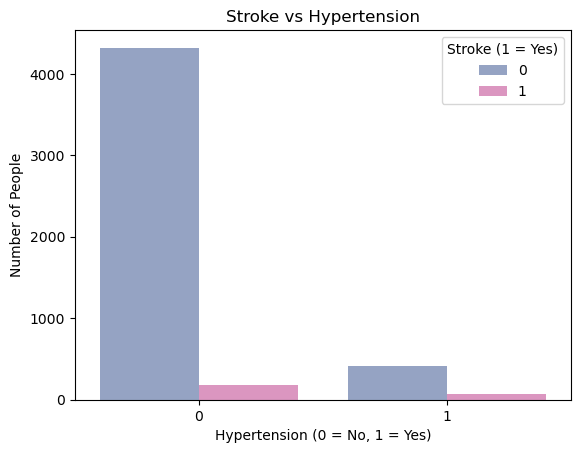

In [38]:
colors = ['#8da0cb', '#e78ac3'] 

#plottingd teh stroke distribution within each hypertension group
sb.countplot(x='hypertension', hue='stroke', data=data, palette=colors)
plt.title('Stroke vs Hypertension')
plt.xlabel('Hypertension (0 = No, 1 = Yes)')
plt.ylabel('Number of People')
plt.legend(title='Stroke (1 = Yes)')
plt.show()

In [39]:
# Group by hypertension status and calculate the mean stroke rate
stroke_rates_hyp = data.groupby('hypertension')['stroke'].mean()

# Print results clearly
print("Stroke Rate by Hypertension Status:")
print(f"Hypertension = 0 (No):  {stroke_rates_hyp[0]:.4f} → {stroke_rates_hyp[0]*100:.2f}%")
print(f"Hypertension = 1 (Yes): {stroke_rates_hyp[1]:.4f} → {stroke_rates_hyp[1]*100:.2f}%")


Stroke Rate by Hypertension Status:
Hypertension = 0 (No):  0.0404 → 4.04%
Hypertension = 1 (Yes): 0.1378 → 13.78%


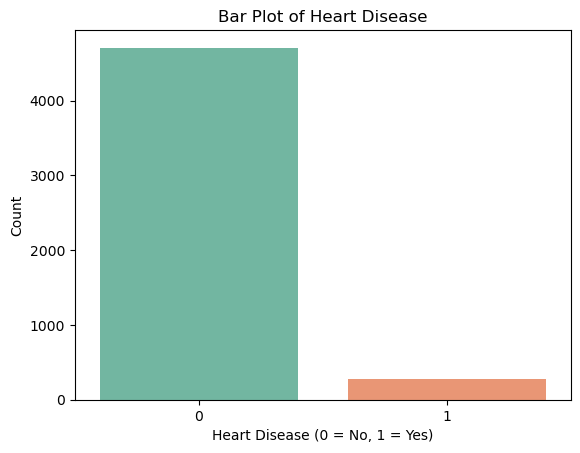

In [40]:
colors = ['#66c2a5', '#fc8d62']

sb.countplot(x='heart_disease', data=data, hue='heart_disease', palette=sb.color_palette(colors), legend=False)

plt.title('Bar Plot of Heart Disease')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

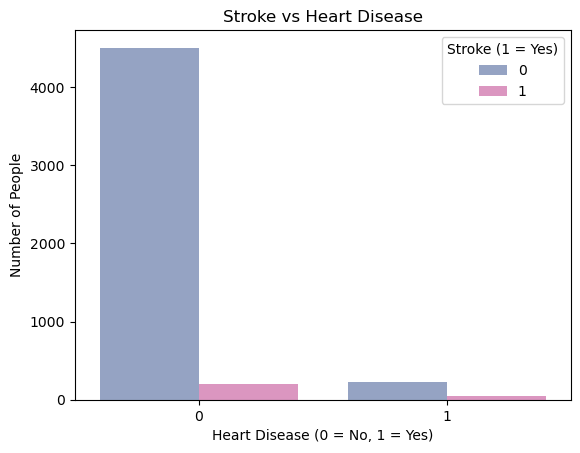

In [41]:
colors = ['#8da0cb', '#e78ac3']

#plotting stroke distribution for people with and without heart disease
sb.countplot(x='heart_disease', hue='stroke', data=data, palette=colors)
plt.title('Stroke vs Heart Disease')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Number of People')
plt.legend(title='Stroke (1 = Yes)')
plt.show()


In [42]:
# Group by heart disease status and calculate the mean stroke rate
stroke_rates = data.groupby('heart_disease')['stroke'].mean()

# Print results clearly
print("Stroke Rate by Heart Disease Status:")
print(f"Heart Disease = 0 (No):  {stroke_rates[0]:.4f} → {stroke_rates[0]*100:.2f}%")
print(f"Heart Disease = 1 (Yes): {stroke_rates[1]:.4f} → {stroke_rates[1]*100:.2f}%")


Stroke Rate by Heart Disease Status:
Heart Disease = 0 (No):  0.0427 → 4.27%
Heart Disease = 1 (Yes): 0.1709 → 17.09%


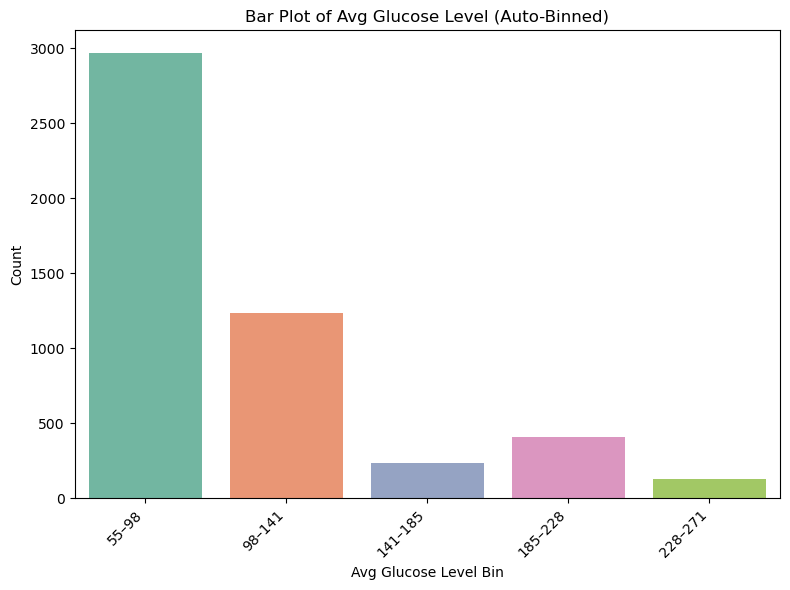

In [43]:
#bar graoh for avg glucose level
min_glucose = data['avg_glucose_level'].min()
max_glucose = data['avg_glucose_level'].max()
bins = np.linspace(min_glucose, max_glucose, 6) 


labels = [f'{int(bins[i])}–{int(bins[i+1])}' for i in range(len(bins) - 1)]

data['glucose_binned'] = pd.cut(data['avg_glucose_level'], bins=bins, labels=labels, include_lowest=True)


plt.figure(figsize=(8, 6))
sb.countplot(x='glucose_binned', data=data, palette='Set2', width=0.8)
plt.title('Bar Plot of Avg Glucose Level (Auto-Binned)')
plt.xlabel('Avg Glucose Level Bin')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


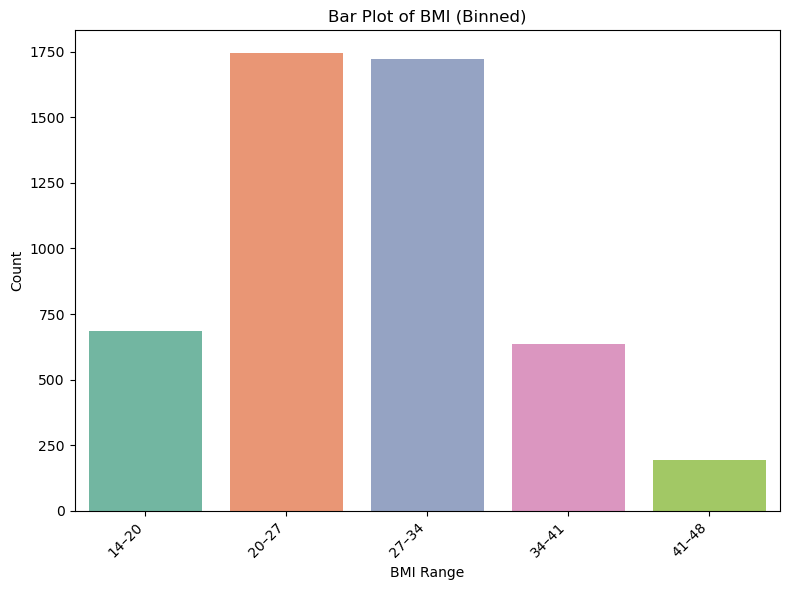

In [44]:

#calculating bin sizes
min_bmi = data['bmi'].min()
max_bmi = data['bmi'].max()
bins = np.linspace(min_bmi, max_bmi, 6)

#bar chart for bmi and countof people in a oarticular range

labels = [f'{int(bins[i])}–{int(bins[i+1])}' for i in range(len(bins)-1)]


data['bmi_binned'] = pd.cut(data['bmi'], bins=bins, labels=labels, include_lowest=True)


plt.figure(figsize=(8, 6))
sb.countplot(x='bmi_binned', data=data, palette='Set2', width=0.8)
plt.title('Bar Plot of BMI (Binned)')
plt.xlabel('BMI Range')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


smoking_status
never smoked       1838
Unknown            1500
formerly smoked     867
smokes              776
Name: count, dtype: int64


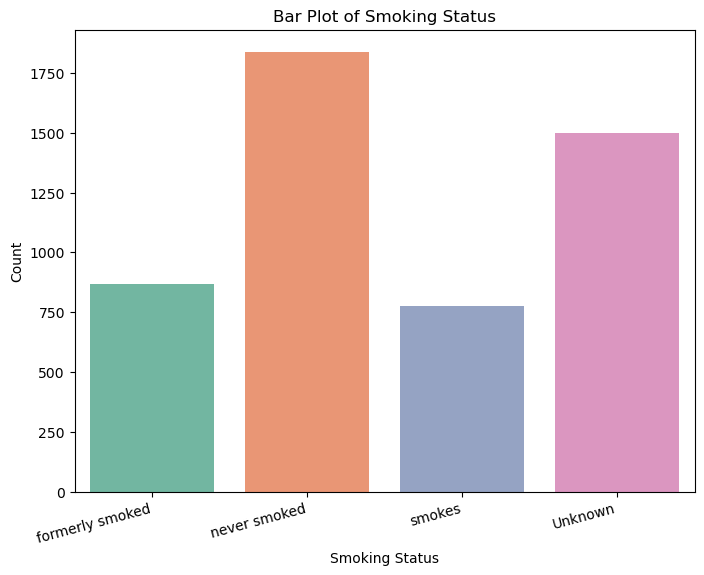

In [45]:
import seaborn as sb
import matplotlib.pyplot as plt

#plotting a bar chart for smoking stat and no of peopel
print(data['smoking_status'].value_counts())

plt.figure(figsize=(8, 6))

sb.countplot(x='smoking_status', data=data, palette='Set2', width=0.8)

plt.title('Bar Plot of Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Count')

plt.xticks(rotation=15, ha='right')

plt.show()


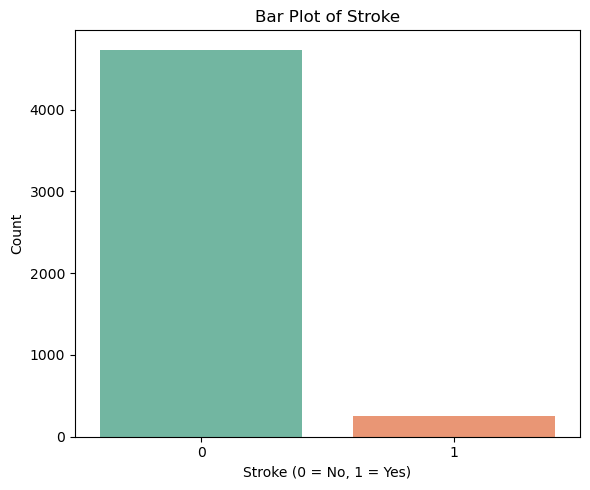

In [46]:
colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(6, 5))


sb.countplot(x='stroke', hue='stroke', data=data, palette=colors, width=0.8, legend=False)

plt.title('Bar Plot of Stroke')
plt.xlabel('Stroke (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

age_band
0-16       2
17-32      1
33-48     13
49-64     73
65+      159
Name: count, dtype: int64


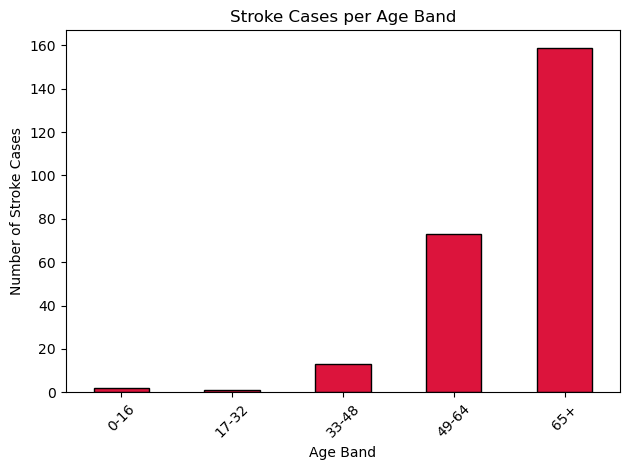

In [47]:
#defining the bins to sort 
bins = [0, 16, 32, 48, 64, np.inf]  #np.inf ensures ages above 65 go into the last category
labels = ['0-16', '17-32', '33-48', '49-64', '65+']

data['age_band'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

#counting the no of people in each age band 
stroke_counts = data[data['stroke'] == 1]['age_band'].value_counts().sort_index()


print(stroke_counts)

#bar chartt
stroke_counts.plot(kind='bar', color='crimson', edgecolor='black')
plt.title('Stroke Cases per Age Band')
plt.xlabel('Age Band')
plt.ylabel('Number of Stroke Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


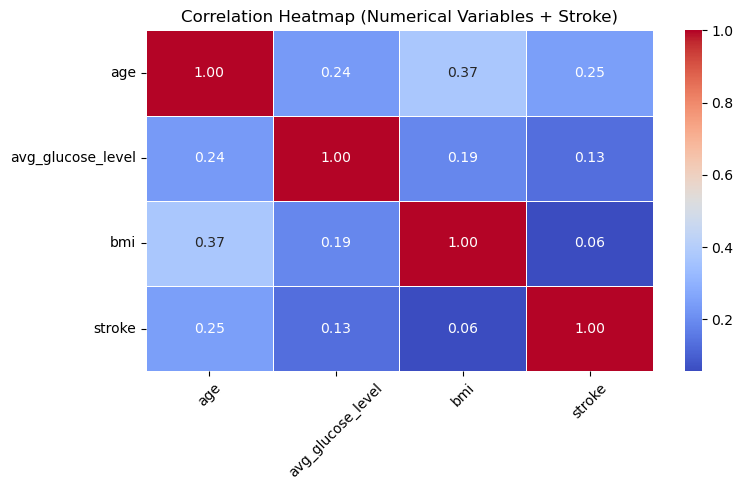

In [48]:
#selecting only the numerical features + target
numerical_cols = ['age', 'avg_glucose_level', 'bmi', 'stroke']
corr_matrix = data[numerical_cols].corr()

#plotting heatmap to visualise 
plt.figure(figsize=(8, 5))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Numerical Variables + Stroke)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Machine Learning Techniques

### 1. Random Forest


=== Random Forest - Train ===
Accuracy: 1.0000
TPR (Recall): 1.0000
FNR: 0.0000
TNR: 1.0000
FPR: 0.0000
Precision: 1.0000
F1 Score: 1.0000
AUC: 1.0000

=== Random Forest - Test ===
Accuracy: 0.9478
TPR (Recall): 0.0000
FNR: 1.0000
TNR: 0.9979
FPR: 0.0021
Precision: 0.0000
F1 Score: 0.0000
AUC: 0.7896


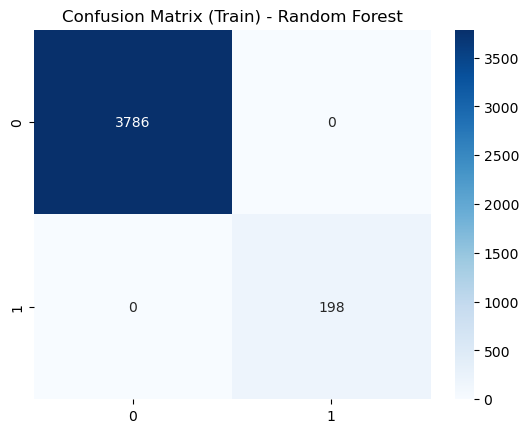

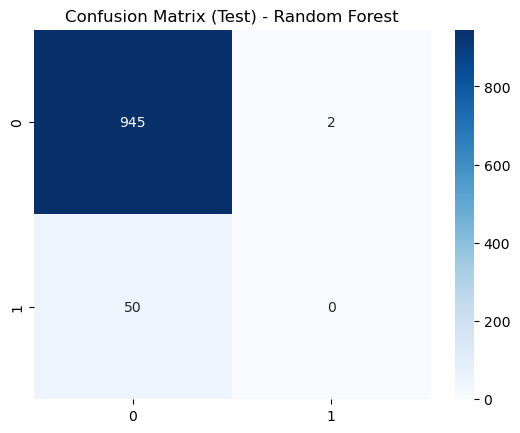

In [49]:
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

#training random forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
y_train_prob = rf.predict_proba(X_train)[:, 1]
y_test_prob = rf.predict_proba(X_test)[:, 1]

#defining an evaluate function to help calculate metrics
def evaluate(y_true, y_pred, y_prob=None):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'TPR (Recall)': recall_score(y_true, y_pred),
        'FNR': fn / (fn + tp) if (fn + tp) != 0 else 0,
        'TNR': tn / (tn + fp) if (tn + fp) != 0 else 0,
        'FPR': fp / (fp + tn) if (fp + tn) != 0 else 0,
        'Precision': precision_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Confusion Matrix': cm
    }
    if y_prob is not None:
        metrics['AUC'] = roc_auc_score(y_true, y_prob)
    return metrics


train_metrics = evaluate(y_train, y_train_pred, y_train_prob)
test_metrics = evaluate(y_test, y_test_pred, y_test_prob)

print("\n=== Random Forest - Train ===")
for k, v in train_metrics.items():
    if k != 'Confusion Matrix':
        print(f"{k}: {v:.4f}")

print("\n=== Random Forest - Test ===")
for k, v in test_metrics.items():
    if k != 'Confusion Matrix':
        print(f"{k}: {v:.4f}")


sb.heatmap(train_metrics['Confusion Matrix'], annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix (Train) - Random Forest")
plt.show()


sb.heatmap(test_metrics['Confusion Matrix'], annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix (Test) - Random Forest")
plt.show()


### 2. Naive Bayes


Naive Bayes - Train
Accuracy: 0.8672
TPR (Recall): 0.4141
FNR: 0.5859
TNR: 0.8909
FPR: 0.1091
Precision: 0.1657
F1 Score: 0.2367
AUC: 0.8187

Naive Bayes - Test
Accuracy: 0.8736
TPR (Recall): 0.3200
FNR: 0.6800
TNR: 0.9029
FPR: 0.0971
Precision: 0.1481
F1 Score: 0.2025
AUC: 0.8171


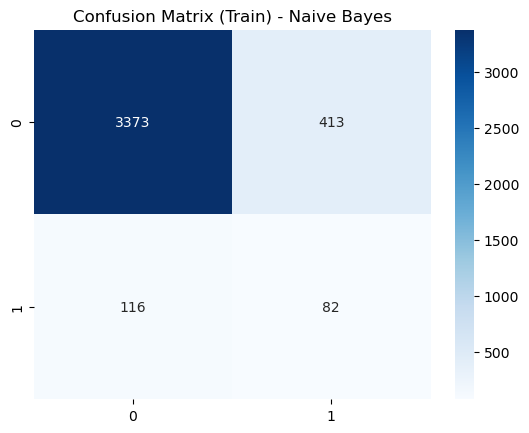

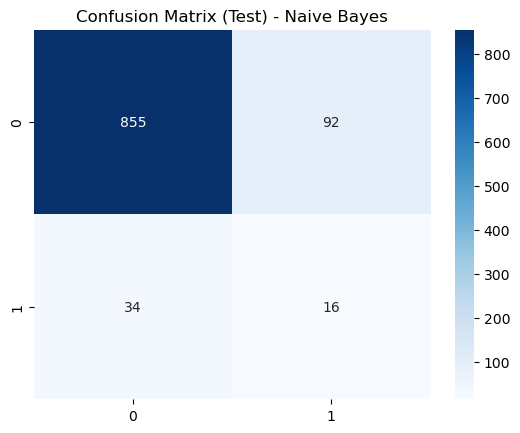

In [50]:
#training for Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)


y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)
y_train_prob = nb.predict_proba(X_train)[:, 1]
y_test_prob = nb.predict_proba(X_test)[:, 1]


train_metrics = evaluate(y_train, y_train_pred, y_train_prob)
test_metrics = evaluate(y_test, y_test_pred, y_test_prob)


print("\nNaive Bayes - Train")
for k, v in train_metrics.items():
    if k != 'Confusion Matrix':
        print(f"{k}: {v:.4f}")


print("\nNaive Bayes - Test")
for k, v in test_metrics.items():
    if k != 'Confusion Matrix':
        print(f"{k}: {v:.4f}")


sb.heatmap(train_metrics['Confusion Matrix'], annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix (Train) - Naive Bayes")
plt.show()


sb.heatmap(test_metrics['Confusion Matrix'], annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix (Test) - Naive Bayes")
plt.show()


### 3. Logistical Regression


Logistic Regression - Train
Accuracy: 0.7344
TPR (Recall): 0.8182
FNR: 0.1818
TNR: 0.7301
FPR: 0.2699
Precision: 0.1368
F1 Score: 0.2344
AUC: 0.8445

Logistic Regression - Test 
Accuracy: 0.7482
TPR (Recall): 0.8600
FNR: 0.1400
TNR: 0.7423
FPR: 0.2577
Precision: 0.1498
F1 Score: 0.2552
AUC: 0.8457


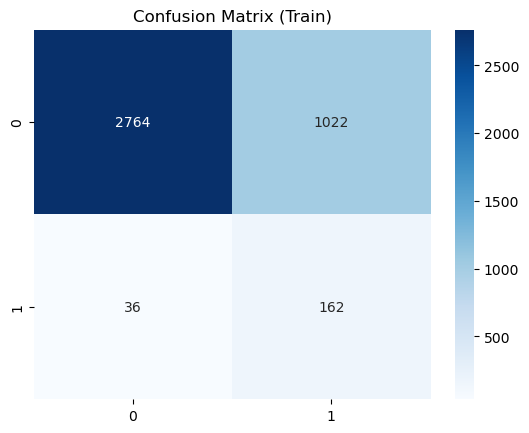

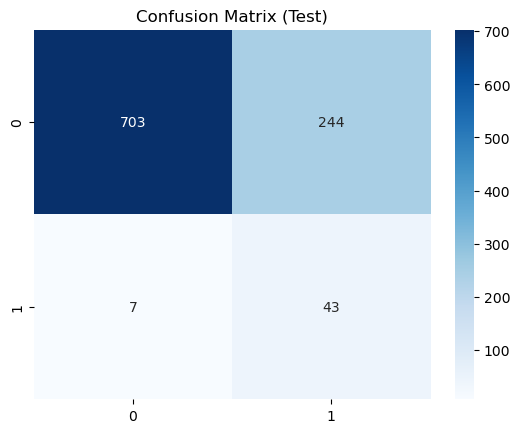

In [51]:
#train the data for logistic regression
lr = LogisticRegression(class_weight='balanced', max_iter=10000)
lr.fit(X_train, y_train)

#predicting on the train data and test data
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
y_train_prob = lr.predict_proba(X_train)[:, 1]
y_test_prob = lr.predict_proba(X_test)[:, 1]


#evaluating the train and test dataset using the evaluatye function defineed earlier
train_metrics = evaluate(y_train, y_train_pred, y_train_prob)
test_metrics = evaluate(y_test, y_test_pred, y_test_prob)

#train 
print("\nLogistic Regression - Train")
for k, v in train_metrics.items():
    if k != 'Confusion Matrix':
        print(f"{k}: {v:.4f}")

#test
print("\nLogistic Regression - Test ")
for k, v in test_metrics.items():
    if k != 'Confusion Matrix':
        print(f"{k}: {v:.4f}")

#plotting confusion matrix
sb.heatmap(train_metrics['Confusion Matrix'], annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix (Train)")
plt.show()

sb.heatmap(test_metrics['Confusion Matrix'], annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix (Test)")
plt.show()


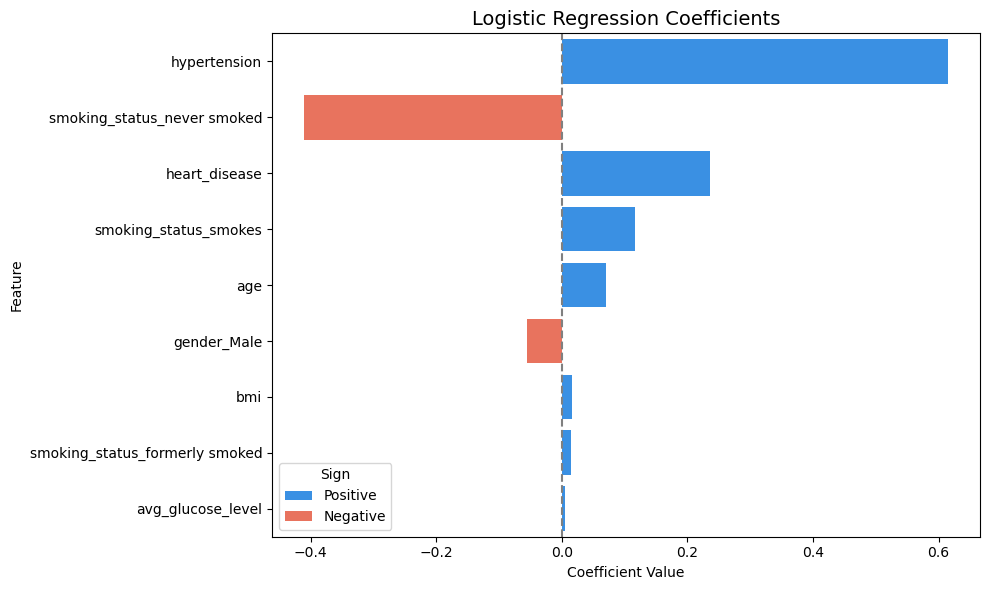

In [52]:
# Create a DataFrame for the coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_[0]
})

# Add a 'Sign' column for coloring
coef_df['Sign'] = coef_df['Coefficient'].apply(lambda x: 'Positive' if x >= 0 else 'Negative')

# Sort features by magnitude for a cleaner plot
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Plotting
plt.figure(figsize=(10, 6))
sb.barplot(
    data=coef_df,
    x='Coefficient',
    y='Feature',
    hue='Sign',
    dodge=False,
    palette={'Positive': 'dodgerblue', 'Negative': 'tomato'}
)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Logistic Regression Coefficients", fontsize=14)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.legend(title='Sign')
plt.tight_layout()
plt.show()
